<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/video_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [2]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media


Python 3.11.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00


In [1]:
### UBFC-rPPG dataset in drive folder
### (TODO) Figure out how to import data set directly into colab
from google.colab import drive

drive.mount('/content/drive')
#filepath = '/content/drive/MyDrive/research_project/'
filepath = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' # @param {type: "string"}
!ls -l $filepath

Mounted at /content/drive
-r-------- 1 root root 1425830568 Nov 16  2017 /content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi


In [5]:
video = media.read_video(filepath)

In [6]:
# Frames per second and number of frames
print(video.metadata.fps)
len(video)

29.26


1547

In [7]:
# width and height
print(video.metadata.shape)

(480, 640)


In [8]:
# size in bytes
print(video.size)

1425715200


original,darkened

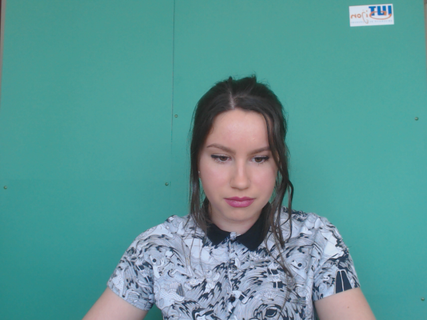
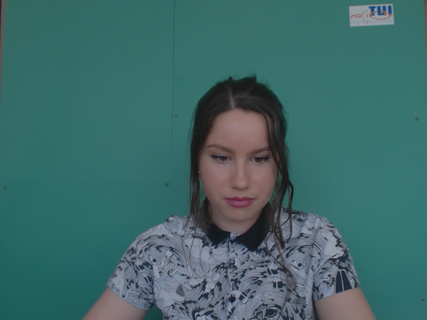

In [10]:
# Darken image
images = {
    'original': video[1],
    'darkened': media.to_float01(video[1]) * 0.7,
}
media.show_images(images, vmin=0.0, vmax=1.0, border=True, height=320)

In [11]:
# Compress the video with default settings (H.264 codec)
COMPRESSION_BIT_RATES = {500_000, 200_000, 100_000}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))

3242186
1303890
658209


In [12]:
# Save the compressed video to a file
with open('/tmp/subject1_500_000.mp4', 'wb') as f:
    f.write(compressed_data[500_000])
with open('/tmp/subject1_200_000.mp4', 'wb') as f:
    f.write(compressed_data[200_000])
with open('/tmp/subject1_100_000.mp4', 'wb') as f:
    f.write(compressed_data[100_000])

In [13]:
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_500_000.mp4')
compressed_video_2 = media.read_video('/tmp/subject1_200_000.mp4')
compressed_video_3 = media.read_video('/tmp/subject1_100_000.mp4')
videos = {'Original': video[:10], 'Compressed_500_000': compressed_video[:10], 'Compressed_200_000': compressed_video_2[:10], 'Compressed_100_000': compressed_video_3[:10]}
media.show_videos(videos, fps=30)

In [16]:
import cv2
from cv2 import dnn_superres

# Create a Super Resolution object
sr = dnn_superres.DnnSuperResImpl_create()

# Read the input image
#image = cv2.imread(<image file>)

# Specify the path to the pre-trained model
model_path = "/content/drive/MyDrive/research_project/vsr_model/EDSR_x4.pb"

# Read the pre-trained model
sr.readModel(model_path)

# Set the model and scale
sr.setModel("edsr", 4)

# Upscale the image
# This takes a while --- very slow
upscaled_image = sr.upsample(compressed_video_2[1])

# Save the upscaled image
cv2.imwrite("./upscaled_image.png", upscaled_image)

print("Image upscaled successfully!")


Image upscaled successfully!


original,upscaled

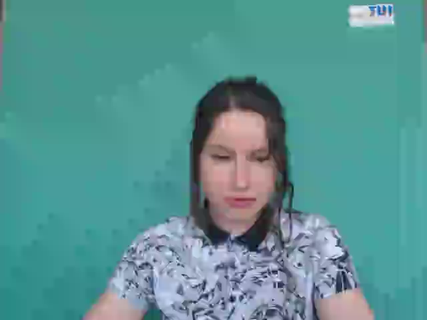
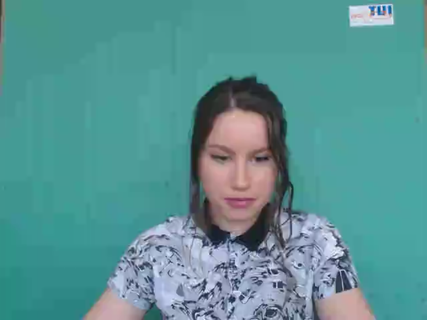

In [17]:
# show side-by-side
images = {
    'original': compressed_video_3[1],
    'upscaled': upscaled_image,
}
media.show_images(images, vmin=0.0, vmax=1.0, border=True, height=320)